# LSTM Lag test

## 0. Imports

In [102]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.dates as mdates

## 1. Read and EDA

In [2]:
#Read the csv file
df = pd.read_csv('henry_csv_17-23.csv')#, infer_datetime_format= True)
renames = {'00065': 'Gage Height', '00060': 'Discharge', '72254': 'Velocity'}
df = df.rename(columns = renames)

df = df[['datetime', 'Discharge', 'Gage Height', 'Velocity']]
df = df.set_index('datetime')
df.dropna(axis = 0, inplace = True)

print(df.head()) #3 columns

C:\Users\emmac\AppData\Local\Temp\ipykernel_27508\80301310.py:2: DtypeWarning: Columns (2,5,11,13,15,17,19,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('henry_csv_17-23.csv')#, infer_datetime_format= True)


                           Discharge  Gage Height  Velocity
datetime                                                   
2017-01-01 00:00:00-06:00    20400.0        16.95      2.45
2017-01-01 00:15:00-06:00    19800.0        16.96      2.37
2017-01-01 00:30:00-06:00    20900.0        16.98      2.51
2017-01-01 00:45:00-06:00    19300.0        16.95      2.32
2017-01-01 01:00:00-06:00    20700.0        16.98      2.49


In [64]:
# Separate dates for future plotting
all_dates = df.index.to_series()
print(all_dates.tail(15)) #Check last few dates.

datetime
2022-12-01 20:15:00-06:00    2022-12-01 20:15:00-06:00
2022-12-01 20:30:00-06:00    2022-12-01 20:30:00-06:00
2022-12-01 20:45:00-06:00    2022-12-01 20:45:00-06:00
2022-12-01 21:00:00-06:00    2022-12-01 21:00:00-06:00
2022-12-01 21:15:00-06:00    2022-12-01 21:15:00-06:00
2022-12-01 21:30:00-06:00    2022-12-01 21:30:00-06:00
2022-12-01 21:45:00-06:00    2022-12-01 21:45:00-06:00
2022-12-01 22:00:00-06:00    2022-12-01 22:00:00-06:00
2022-12-01 22:15:00-06:00    2022-12-01 22:15:00-06:00
2022-12-01 22:30:00-06:00    2022-12-01 22:30:00-06:00
2022-12-01 22:45:00-06:00    2022-12-01 22:45:00-06:00
2022-12-01 23:00:00-06:00    2022-12-01 23:00:00-06:00
2022-12-01 23:15:00-06:00    2022-12-01 23:15:00-06:00
2022-12-01 23:30:00-06:00    2022-12-01 23:30:00-06:00
2022-12-01 23:45:00-06:00    2022-12-01 23:45:00-06:00
Name: datetime, dtype: object


In [67]:
# Check out the dataset
df

,Discharge,Gage Height,Velocity
datetime,,,
2017-01-01 00:00:00-06:00,20400.0,16.95,2.45
2017-01-01 00:15:00-06:00,19800.0,16.96,2.37
2017-01-01 00:30:00-06:00,20900.0,16.98,2.51
2017-01-01 00:45:00-06:00,19300.0,16.95,2.32
2017-01-01 01:00:00-06:00,20700.0,16.98,2.49
...,...,...,...
2022-12-01 22:45:00-06:00,4510.0,14.83,0.60
2022-12-01 23:00:00-06:00,3800.0,14.87,0.50
2022-12-01 23:15:00-06:00,3440.0,14.88,0.45


## Data manipulation

In [5]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# Scale before splitting to scale the range of the whole dataset uniformally
# Normalize the dataset

scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)

In [6]:
df_scaled

array([[ 0.20959378, -0.13987508,  0.78355675],
       [ 0.16634792, -0.13691045,  0.69871099],
       [ 0.245632  , -0.13098117,  0.84719107],
       ...,
       [-1.01282265, -0.75355472, -1.33758719],
       [-1.0077773 , -0.75651935, -1.32698147],
       [-0.99264125, -0.75948399, -1.29516431]])

In [7]:
# Convert from an array to dataframe
df_scaled = pd.DataFrame(df_scaled, columns = ['Discharge','Gage Height','Velocity'], index=df.index)

print(df_scaled)
print(type(df_scaled))

                           Discharge  Gage Height  Velocity
datetime                                                   
2017-01-01 00:00:00-06:00   0.209594    -0.139875  0.783557
2017-01-01 00:15:00-06:00   0.166348    -0.136910  0.698711
2017-01-01 00:30:00-06:00   0.245632    -0.130981  0.847191
2017-01-01 00:45:00-06:00   0.130310    -0.139875  0.645682
2017-01-01 01:00:00-06:00   0.231217    -0.130981  0.825980
...                              ...          ...       ...
2022-12-01 22:45:00-06:00  -0.935701    -0.768378 -1.178501
2022-12-01 23:00:00-06:00  -0.986875    -0.756519 -1.284559
2022-12-01 23:15:00-06:00  -1.012823    -0.753555 -1.337587
2022-12-01 23:30:00-06:00  -1.007777    -0.756519 -1.326981
2022-12-01 23:45:00-06:00  -0.992641    -0.759484 -1.295164

[199343 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [68]:
# Subset the train/testing data
# Train: 2017-2018, 2020
# Test: 2019, 2021

train_scaled = df_scaled['2017':'2020'] # Years 2017, 2018 and 2019 (this includes training and validation data)
test_scaled = df_scaled['2020':'2021'] # Year of 2020

In [69]:
test_scaled

,Discharge,Gage Height,Velocity
datetime,,,
2020-01-01 00:00:00-06:00,0.483484,0.011321,1.218391
2020-01-01 00:15:00-06:00,0.360954,-0.000537,0.995671
2020-01-01 00:30:00-06:00,0.447446,0.005392,1.154757
2020-01-01 00:45:00-06:00,0.440238,0.008357,1.133546
2020-01-01 01:00:00-06:00,0.490692,0.008357,1.228997
...,...,...,...
2020-12-31 22:45:00-06:00,-0.796593,-0.774307,-0.892147
2020-12-31 23:00:00-06:00,-0.719472,-0.777272,-0.733061
2020-12-31 23:15:00-06:00,-0.756951,-0.786166,-0.807301


In [70]:
# We do not want to be training with the discharge we are attempting to replace
dfx = train_scaled.drop("Discharge", axis= 1) 
dfx

,Gage Height,Velocity
datetime,,
2017-01-01 00:00:00-06:00,-0.139875,0.783557
2017-01-01 00:15:00-06:00,-0.136910,0.698711
2017-01-01 00:30:00-06:00,-0.130981,0.847191
2017-01-01 00:45:00-06:00,-0.139875,0.645682
2017-01-01 01:00:00-06:00,-0.130981,0.825980
...,...,...
2019-12-31 22:45:00-06:00,-0.003502,1.154757
2019-12-31 23:00:00-06:00,-0.000537,1.144151
2019-12-31 23:15:00-06:00,-0.000537,1.133546


In [74]:
# Separate dates for future plotting
train_dates = train_scaled.index.to_series()
print(train_dates.tail(3)) #Check last few dates.
test_dates = test_scaled.index.to_series()
print(test_dates.tail(3)) #Check last few dates.

datetime
2019-12-31 23:15:00-06:00    2019-12-31 23:15:00-06:00
2019-12-31 23:30:00-06:00    2019-12-31 23:30:00-06:00
2019-12-31 23:45:00-06:00    2019-12-31 23:45:00-06:00
Name: datetime, dtype: object
datetime
2020-12-31 23:15:00-06:00    2020-12-31 23:15:00-06:00
2020-12-31 23:30:00-06:00    2020-12-31 23:30:00-06:00
2020-12-31 23:45:00-06:00    2020-12-31 23:45:00-06:00
Name: datetime, dtype: object


In [75]:
# Convert 
train_scaled = train_scaled.to_numpy()
test_scaled = test_scaled.to_numpy()
dfx = dfx.to_numpy()

## LSTM

In [12]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 3. We will make timesteps = 672 (past 7 days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

time_to_hr = 4 # 4 timesteps per hour
time_to_day = time_to_hr * 24 # 24hrs in a day

n_future = 12 # Number of timesteps we want to look into the future based on the past timesteps. 4 * 3hrs = 12
n_past = 3 * time_to_day # Number of past timesteps we want to use to predict the future. 7 days x 24hrs x 4 timesteps/hr = 672

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(train_scaled) - n_future +1):
    trainX.append(dfx[i - n_past : i, 0:train_scaled.shape[1]])
    
    trainY.append(train_scaled[i + n_future - 1:i + n_future, 0]) #0 = Discharge

trainX, trainY = np.array(trainX), np.array(trainY)


print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (100609, 288, 2).
trainY shape == (100609, 1).


## Model Dev

In [40]:
import os

os.getcwd()

'C:\\Users\\emmac\\Documents\\GitHub\\Hysterisis-ML-Modeling'

In [13]:
# Don't retrain unless necessary

# Verify the shape aligns with the training data shape above!
# If not, retrain!

model_lstm = tf.keras.models.load_model('./saved_model/LSTM_Saved_Henry_2017_2019')  ##! Loading the model is giving me issues
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               64000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 64,126
Trainable params: 64,126
Non-trainable params: 0
_________________________________________________________________


In [42]:

#In my case, trainX has a shape (100301, 672, 3).

#100301 because we are looking back 672 timesteps ##(12823 - 14 = 12809).
#Remember that we cannot look back 12 timesteps until we get to the 13th timesteps.

#Also, trainY has a shape (100301, 1). Our model only predicts a single value, but
#it needs multiple variables (5 in my example) to make this prediction.
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have.
#We need to predict all variables if we want to do that.

# define the Autoencoder model

#'''
# The LSTM architecture -- Basic RNN | one layer then dense
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(trainX.shape[1], trainX.shape[2])))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

batch_size = 16
model_lstm.fit(trainX, trainY, epochs=10, batch_size=batch_size, verbose=1)
#'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               64000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 64,126
Trainable params: 64,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6289/6289 [==============================] - 949s 150ms/step - loss: 0.0187
Epoch 2/10
6289/6289 [==============================] - 822s 131ms/step - loss: 0.0141
Epoch 3/10
6289/6289 [==============================] - 831s 132ms/step - loss: 0.0133
Epoch 4/10
6289/6289 [==============================] - 817s 130ms/step - loss: 0.0129
Epoch 5/10
6289/6289 [==============================] - 824s 131ms/step - loss: 0.0120
Epoch 6/10
62

In [43]:
## Save the entire model as a SavedModel
import os
#if not "saved_model" in os.listdir(): #If the saved model directory doesn't exist, make it    
#    !mkdir -p saved_model
    
model_lstm.save('saved_model/LSTM_Saved_Henry_2017_2019')


INFO:tensorflow:Assets written to: saved_model/LSTM_Saved_Henry_2017_2019\assets


INFO:tensorflow:Assets written to: saved_model/LSTM_Saved_Henry_2017_2019\assets


### Other models


In [ ]:
'''
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=1, batch_size=16, validation_split=0.1, verbose=1)
'''
""" plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()"""
'''
#Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/LSTM_Saved_Mikey_1')
#'''
## Predictions

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 64)           17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Exception ignored in: <function UniquePtr.__del__ at 0x000002664CBCB8B0>
Traceback (most recent call last):
  File "C:\Users\perso\anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
KeyboardInterrupt: 


1046/7551 [===>..........................] - ETA: 1:18:09 - loss: nan

### Transform the test data

In [14]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               64000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 64,126
Trainable params: 64,126
Non-trainable params: 0
_________________________________________________________________


In [16]:
testX = []
testY = []

n_future = 12 # Number of timesteps we want to look into the future based on the past timesteps. 4 * 3hrs = 12
n_past = 3 * time_to_day

In [17]:
for i in range(n_past, len(test_scaled) - n_future +1):
    testX.append(test_scaled[i - n_past:i, 1 : test_scaled.shape[1]]) # Start at [1]: (excludes discharge)
    testY.append(test_scaled[i + n_future - 1 : i + n_future, 0]) # 0 = Discharge

testX, testY = np.array(testX), np.array(testY)

In [18]:
testX.shape # (Only velocity and WL)

(33705, 288, 2)

In [19]:
#Make prediction
# Will only use the last 7 days of the training data to predict X number of days into the testing data
prediction = model_lstm.predict(testX, verbose = 1)

1054/1054 [==============================] - 54s 50ms/step


In [91]:
# Perform inverse transformation to rescale back to original range
# Since we used 3 variables for transform, the inverse expects same dimensions
prediction_copies = np.repeat(prediction, test_scaled.shape[1], axis=-1)

# Scale two datasets
y_pred = scaler.inverse_transform(prediction_copies)[:, 0]  # Location of Discharge in columns
test = scaler.inverse_transform(test_scaled)[:]  # Location of Discharge in columns

In [92]:
# Convert test from array to dataframes 
test = pd.DataFrame(test, columns = ['Discharge','Gage Height','Velocity'], index=test_dates.index)

# Cut off the last part of the test data --- #? WHY do we do this? I know why but not 100% sure WHY why
test_predicts = test[:-n_past -11].copy()

# Convert y_pred from array to dataframes 
y_pred = pd.DataFrame(y_pred, columns = ['Predicted Discharge'], index=test_predicts.index)

In [94]:
# Add prediction as column
test_predicts["Predicted Discharge"] = y_pred
test_predicts

,Discharge,Gage Height,Velocity,Predicted Discharge
datetime,,,,
2020-01-01 00:00:00-06:00,24200.0,17.46,2.86,19807.849609
2020-01-01 00:15:00-06:00,22500.0,17.42,2.65,19718.570312
2020-01-01 00:30:00-06:00,23700.0,17.44,2.80,19511.531250
2020-01-01 00:45:00-06:00,23600.0,17.45,2.78,19651.212891
2020-01-01 01:00:00-06:00,24300.0,17.45,2.87,19732.201172
...,...,...,...,...
2020-12-28 18:15:00-06:00,5970.0,14.73,0.81,7568.880859
2020-12-28 18:30:00-06:00,5680.0,14.73,0.77,7722.186523
2020-12-28 18:45:00-06:00,5970.0,14.73,0.81,7370.754883


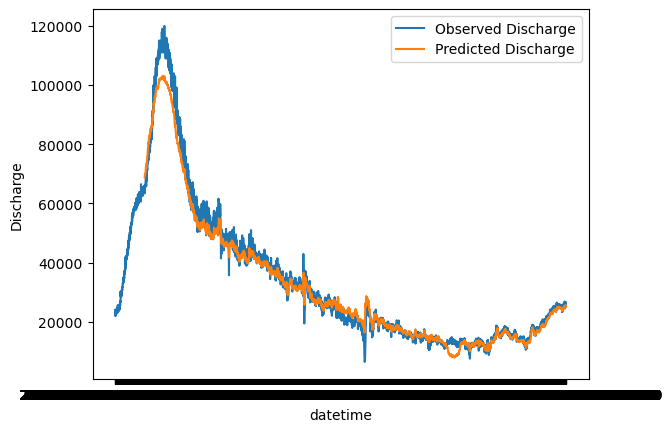

In [109]:
# Plot one event to examine model performance
tstart = '2020-05-15 00:00:00-00:00' #'2021-06-15'
tend = '2020-07-01 00:00:00-00:00'#'2021-07-20'

sns.lineplot(test['Discharge'][tstart : tend], errorbar= None)
sns.lineplot(test_predicts["Predicted Discharge"][tstart : tend].shift(n_past), errorbar= None)
# shifting 7 to overlay due to inherent shifting from original formatting of the data.

# Set Legend
plt.legend(labels=["Observed Discharge","Predicted Discharge"])

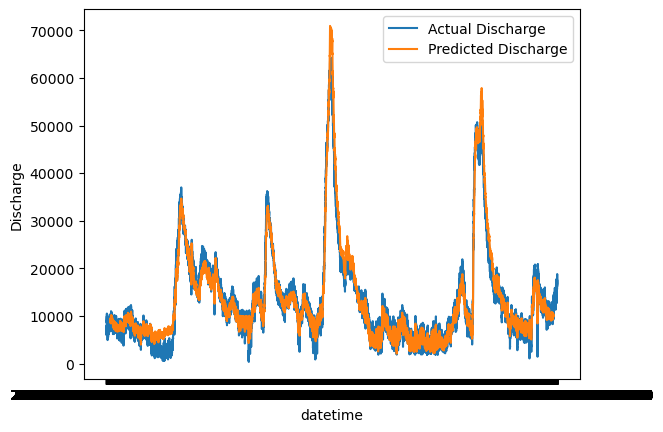

In [35]:
# Plot whole test year to examine model performance (this takes a little while to run)
tstart = '2021-01-01'
tend = '2021-12-31'
sns.lineplot(test['Discharge'], errorbar= None)
sns.lineplot(test_predicts["Predicted Discharge"].shift(n_past), errorbar= None)
# shifting 7 to overlay due to inherent shifting from original formatting of the data.

plt.legend(labels=["Actual Discharge","Predicted Discharge"])

In [37]:
# Evaluate model using statistics
# First load them in
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

In [38]:
# Report mean squared log error
mean_squared_log_error(test['Discharge'][:-n_past-11], test_predicts["Predicted Discharge"])

0.18970896423009212

In [39]:
# Report mean squared error
mean_squared_error(test['Discharge'][:-n_past-11], test_predicts["Predicted Discharge"])

40063875.04360296

In [40]:
# Report R2
r2_score(test['Discharge'][:-n_past-11], test_predicts["Predicted Discharge"])

0.622771435658164

## Future Predictions


In [110]:
# Run test
# Prediction
#pred_WL = model_lstm.predict(testX)
n_future_pred = 3 * time_to_hr
overlap = 1
pred_dis = model_lstm.predict(testX[-n_future_pred - overlap:])


pred_dis = np.repeat(pred_dis, test.shape[1], axis=-1)
future_dis = scaler2.inverse_transform(pred_dis)[:, 0]  # Location of Discharge in columns


1/1 [==============================] - 0s 56ms/step


In [111]:
predict_period_dates = pd.date_range(list(test.index)[-(overlap)],periods=n_future_pred + overlap, freq='15min').to_numpy()
predict_period_dates

array([Timestamp('2021-12-31 23:45:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 00:00:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 00:15:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 00:30:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 00:45:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 01:00:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 01:15:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 01:30:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 01:45:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 02:00:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 02:15:00-0600', tz='pytz.FixedOffset(-360)', freq='15T'),
       Timestamp('2022-01-01 02:30:00-0600'

In [112]:
predict_period_dates.shape

(13,)

In [113]:
future_dis = np.reshape(future_dis, (len(future_dis),))

In [115]:
'''
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
len(y_pred_future)
'''
df_forecast = pd.DataFrame({'Date': pd.to_datetime(predict_period_dates),
                            'Discharge':future_dis})

In [116]:
df_forecast.set_index('Date', inplace= True)

In [117]:
original = df[['Discharge']]
original = original.loc['2021-12-25': '2022']

In [118]:
joint_df = pd.concat([original, df_forecast])

                           Discharge
datetime                            
2021-12-31 23:45:00-06:00    16800.0


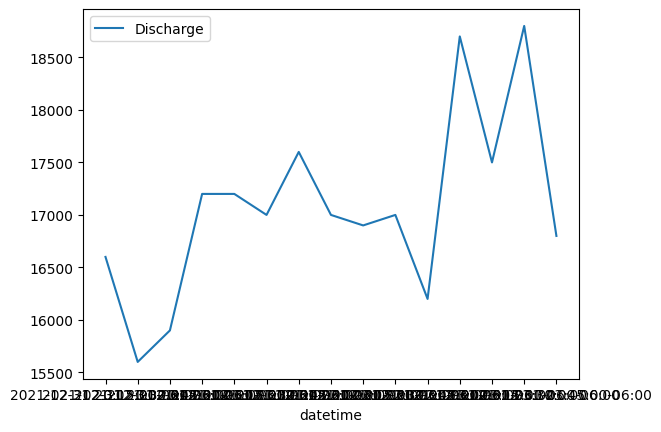

In [136]:
sns.lineplot(original[-15:], errorbar= None)
print(original[-1:])

,Discharge
Date,
2021-12-31 23:45:00-06:00,15411.088867


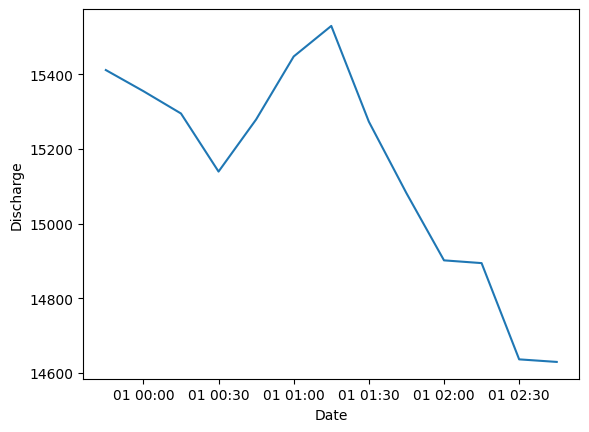

In [139]:
sns.lineplot(df_forecast, x= "Date", y= "Discharge", errorbar= None)
df_forecast[:1]

,Gage Height
Date,
2022-12-01 00:00:00-06:00,0.959061
2022-12-01 00:15:00-06:00,0.948979
2022-12-01 00:30:00-06:00,0.939894
2022-12-01 00:45:00-06:00,0.954180
2022-12-01 01:00:00-06:00,0.956698
2022-12-01 01:15:00-06:00,0.951986
2022-12-01 01:30:00-06:00,0.951351
2022-12-01 01:45:00-06:00,0.944818
2022-12-01 02:00:00-06:00,0.943667


In [ ]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])
